In [1]:
!pip install huspacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-core 0.3.18 requires packaging<25,>=23.2, but you have packaging 21.3 which is incompatible.
pandas-gbq 0.24.0 requires packaging>=22.0.0, but you have packaging 21.3 which is incompatible.
sphinx 8.1.3 requires packaging>=23.0, but you have packaging 21.3 which is incompatible.
xarray 2024.10.0 requires packaging>=23.1, but you have packaging 21.3 which is incompatible.


In [1]:
import huspacy
huspacy.download()

['/usr/bin/python3', '-m', 'pip', 'install', 'hu_core_news_lg @ https://huggingface.co/huspacy/hu_core_news_lg/resolve/v3.8.0/hu_core_news_lg-any-py3-none-any.whl']


In [2]:
!git clone https://github.com/yarathealmighty/dumps.git
!cd dumps/data
!git clone https://https://huggingface.co/datasets/yarathealmighty/dumps
!pip install datasets
!pip install spacy_syllables
# not necessary, just prettier logging
!pip install tqdm
!pip install praw
!pip install -U matplotlib
!pip install shap

Cloning into 'dumps'...
remote: Enumerating objects: 338, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 338 (delta 95), reused 46 (delta 18), pack-reused 183 (from 1)
Receiving objects: 100% (338/338), 113.15 MiB | 24.64 MiB/s, done.
Resolving deltas: 100% (175/175), done.
Updating files: 100% (28/28), done.
fatal: destination path 'dumps' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully 

In [3]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import dumps.utils as utils
from collections import Counter

from tqdm import tqdm
import huspacy
from spacy_syllables import SpacySyllables

from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import shap

In [4]:
nlp_hu = huspacy.load()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'hu_core_news_lg' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [5]:
nlp_hu.add_pipe('syllables', after='tagger')
nlp_hu.pipe_names

['tok2vec',
 'senter',
 'tagger',
 'syllables',
 'morphologizer',
 'lookup_lemmatizer',
 'trainable_lemmatizer',
 'parser',
 'ner']

In [6]:
def get_qas(df, tokenize=False, debug_stopwords=False, debug_original=True):
    data = []

    for idx, row in tqdm(df.iterrows(), desc='Getting Question-Answer-Score trios', total=len(df)):
        question_text = row['text'].lower()

        # Tokenize the question if enabled
        tokenized_question = None
        if tokenize:
            doc_question = nlp_hu(question_text)
            tokenized_question = [token for token in doc_question if not token.is_stop and not token.is_punct and not token.is_emoji] if not debug_stopwords else list(doc_question)

        # Process each answer in comments
        for comment in row['comments']:
            if utils.contains_media(comment['body']):
                continue

            answer_text = comment['body'].lower()
            score = comment['ups']

            # Tokenize the answer if enabled
            tokenized_answer = None
            if tokenize:
                doc_answer = nlp_hu(answer_text)
                tokenized_answer = [token for token in doc_answer if not token.is_stop and not token.is_punct] if not debug_stopwords else list(doc_answer)

            # Append data for each processed comment
            if debug_original:
                if tokenize:
                    data.append((question_text, answer_text, score, tokenized_question, tokenized_answer))
                else:
                    data.append((question_text, answer_text, score))
            else:
                if tokenize:
                    data.append((tokenized_question, tokenized_answer, score))
                else:
                    data.append((question_text, answer_text, score))

    # Create DataFrame based on debug_original and tokenize flags
    if debug_original:
        if tokenize:
            df_result = pd.DataFrame(data, columns=['question', 'answer', 'score', 'tokenized_question', 'tokenized_answer'])
        else:
            df_result = pd.DataFrame(data, columns=['question', 'answer', 'score'])
    else:
        if tokenize:
            df_result = pd.DataFrame(data, columns=['question', 'answer', 'score'])
        else:
            df_result = pd.DataFrame(data, columns=['question', 'answer', 'score'])

    return df_result

def after_clean(df):
    new_token_answers = []
    new_token_questions = []
    for row in tqdm(df.iterrows(), desc='Cleaning some stuff up', total=len(df)):
        if type(row[1]['tokenized_answer']) is str:
            tmp_a = [utils.remove_whitespace(utils.remove_emojis(token[:-1])) for token in row[1]['tokenized_answer'].split(' ') if utils.remove_whitespace(utils.remove_emojis(token[:-1])) != '']
        else:
            tmp_a = [utils.remove_whitespace(utils.remove_emojis(str(token))) for token in list(row[1]['tokenized_answer']) if utils.remove_whitespace(utils.remove_emojis(str(token))) != '']
        if type(row[1]['tokenized_question']) is str:
            tmp_q = [utils.remove_whitespace(utils.remove_emojis(token[:-1])) for token in row[1]['tokenized_question'].split(' ') if utils.remove_whitespace(utils.remove_emojis(token[:-1])) != '']
        else:
            tmp_q = [utils.remove_whitespace(utils.remove_emojis(str(token))) for token in list(row[1]['tokenized_question']) if utils.remove_whitespace(utils.remove_emojis(str(token))) != '']
        if tmp_a[0][0] == '[':
            tmp_a[0] = tmp_a[0][1:]
        if tmp_q[0][0] == '[':
            tmp_q[0] = tmp_q[0][1:]
        for i in range(len(tmp_a)):
            if tmp_a[i] == '':
                tmp_a[i] = 'NaN'
            if tmp_a[i][0] == '\'':
                tmp_a[i] = tmp_a[i][1:]
            if tmp_a[i][-1] == '\'':
                tmp_a[i] = tmp_a[i][:-1]
        for i in range(len(tmp_q)):
            if tmp_q[i][0] == '\'':
                tmp_q[i] = tmp_q[i][1:]
            if tmp_q[i][-1] == '\'':
                tmp_q[i] = tmp_q[i][:-1]
        new_token_answers.append(tmp_a)
        new_token_questions.append(tmp_q)
    df['tokenized_answer'] = new_token_answers
    df['tokenized_question'] = new_token_questions
    return df

def get_common_words(df):

  # may need some better solution
  no_no_list = [',','.','?','!',':','*','"','(',')','[',']','{','}','-','','“','”','\\','/','\'','\\n','\\n\\n','<','>','_','^','˘','~','|','&','…']
  new_common_words = []
  jaccard_indices = []

  for row in tqdm(df.iterrows(), desc='Getting common words between questions and answers', total=len(df)):
    tok_a = row[1]['tokenized_answer']
    tok_q = row[1]['tokenized_question']
    c = Counter()
    for token in tok_a:
      c[token] += 1
    for token in tok_q:
      c[token] += 1
    common_words = [token.strip() for token in c if c[token] > 1 and token not in no_no_list and len(token) != 0]
    new_common_words.append(common_words)
    # metszet / a + b - metszet (összes)
    jaccard_indices.append(len(common_words)/(len(tok_a)+len(tok_q)-len(common_words)))
  df['common_words'] = new_common_words
  df['jaccard_index'] = jaccard_indices
  return df

def flesch_kincaid(df):
  answer_flesch_kincaid_scores = []
  question_flesch_kincaid_scores = []

  for row in tqdm(df.iterrows(), desc='Calculating Flesch-Kincaid score for each question and answer', total=len(df)):
    doc_answer = nlp_hu(row[1]['answer'])
    doc_question = nlp_hu(row[1]['question'])

    answer_total_words = len(doc_answer)
    question_total_words = len(doc_question)

    answer_total_sentences = len(list(doc_answer.sents))
    question_total_sentences = len(list(doc_question.sents))

    answer_total_syllables = sum(token._.syllables_count for token in doc_answer if token._.syllables_count is not None)
    question_total_syllables = sum(token._.syllables_count for token in doc_question if token._.syllables_count is not None)

    # formula from wikipedia
    answer_flesch_kincaid_score = 206.835 - 1.015 * (answer_total_words / answer_total_sentences) - 84.6 * (answer_total_syllables / answer_total_words)
    question_flesch_kincaid_score = 206.835 - 1.015 * (question_total_words / question_total_sentences) - 84.6 * (question_total_syllables / question_total_words)

    answer_flesch_kincaid_scores.append(answer_flesch_kincaid_score)
    question_flesch_kincaid_scores.append(question_flesch_kincaid_score)

  df['flesch_kincaid_answer'] = answer_flesch_kincaid_scores
  df['flesch_kincaid_question'] = question_flesch_kincaid_scores
  return df

def pre_vec(df):
    texts = []
    for row in tqdm(df.iterrows(),desc='Preparing questions and answers for vectorization',total=len(df)):
        text = " ".join(row[1]['tokenized_question'])
        text += "[SEP_TOKEN]"
        text += " ".join(row[1]['tokenized_answer'])
        text += "[SEP_TOKEN]"
        text += " ".join(row[1]['common_words'])
        text += "[END_TOKEN]"
        texts.append(text)
    df['pre_vec_text'] = texts
    return df

def predict_linear(question,answer,model):
    doc_question = nlp_hu(question)
    tokenized_question = [token for token in doc_question if not token.is_stop and not token.is_punct]
    doc_answer = nlp_hu(answer)
    tokenized_answer = [token for token in doc_answer if not token.is_stop and not token.is_punct]

    df_tmp = pd.DataFrame({
        'question': question,
        'answer': answer,
        'tokenized_question': [tokenized_question],
        'tokenized_answer': [tokenized_answer]
    })

    df_tmp = after_clean(df_tmp)
    df_tmp = get_common_words(df_tmp)
    df_tmp = utils.calculate_cosine_similarity(df_tmp)
    df_tmp = flesch_kincaid(df_tmp)

    input = pre_vec(df_tmp)
    texts_tfidf = vectorizer.transform(input['pre_vec_text'])

    tfidf_df = pd.DataFrame(texts_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

    input = pd.concat([input, tfidf_df], axis=1)

    input = input.drop(columns=['question','answer','tokenized_question','tokenized_answer','common_words','pre_vec_text'])
    row = input.iloc[0,:].values.reshape(1,-1)
    pred = model.predict(row)
    return pred

def linear_regression_with_threshold(X,y,model,error_threshold=0.1,debug_full_df=False):
    outputs = []
    good_rows = []
    bad_rows = []
    for i in tqdm(range(len(X)),desc='Regressing...',total=len(X)):
        row = X.iloc[i,:].values.reshape(1,-1)
        pred = model.predict(row)
        outputs.append(pred[0])

    if debug_full_df:
        X['lin_reg_pred'] = outputs

    for i in range(len(y)):
        error = abs(float(outputs[i]) - float(y[i]))
        if error <= error_threshold:
            good_rows.append(X.iloc[i,:])
        else:
            bad_rows.append(X.iloc[i,:])

    df_bad = pd.DataFrame(np.array(bad_rows),
                          #columns=['question','answer','tokenized_question','tokenized_answer','score','common_words','jaccard_index','cosine_similarity','flesch_kincaid_answer','flesch_kincaid_question','lin_reg_pred']
                          )
    df_good = pd.DataFrame(np.array(good_rows),
                           #columns=['question','answer','tokenized_question','tokenized_answer','score','common_words','jaccard_index','cosine_similarity','flesch_kincaid_answer','flesch_kincaid_question','lin_reg_pred']
                           )
    if not debug_full_df:
      print(f'[ACCURACY] {len(df_good)/len(X)*100}%')
    return {'correct':df_good,'incorrect':df_bad}

In [108]:
DEBUG = False

if DEBUG:
  # get dataset and load it in as pandas df
  # credit to Bazsalanszky for collecting the posts
  ds = load_dataset("Bazsalanszky/reddit_hu")
  df = ds['train'].to_pandas()
  df1 = df[df['subreddit']=='askhungary']
  df2 = df1[df1['is_video']==False]
  df3 = df2.drop(columns=['author_flair_text','is_video','subreddit','num_crossposts','subreddit_subscribers','url','treatment_tags','all_awardings','is_crosspostable','after'])
  df4 = df3[df3['comments'].notna()]

  # append titles and bodies
  text = []
  for row in df4.iterrows():
    row_text = row[1]['title'] + ' ' + row[1]['selftext']
    text.append(row_text)
  df4['text'] = text

  # leave only questions in (brute force '?' search)
  df5 = df4[df4['text'].str.contains('\?')]

  # very specific drop, print to see why
  df5 = df5[2:]

  df5 = df5.drop_duplicates(subset='title')

  # get question-answer-score trios from the posts and comments
  df = get_qas(df5,tokenize=True,debug_stopwords=False,debug_original=True)
  df = after_clean(df5)

  # normalize scores
  normalized = utils.normalize_scores(df,True)
  normalized.to_csv('big_qas.csv')

  df = df.dropna(subset=['score','tokenized_question','tokenized_answer'])
  df = df[df['tokenized_answer'].apply(lambda x: x != [''])]
  df = df[df['tokenized_question'].apply(lambda x: x != [''])]

  # TODO more elegant solution
  df = get_common_words(df)

  # cosine similartiy
  df = utils.calculate_cosine_similarity(df)

  # readibility
  # needs a ton of time (at least 1-2 hours)
  df = flesch_kincaid(df)

  df.to_csv('big_qas.csv')

else:
  # quick load, less RAM
  ds = load_dataset("yarathealmighty/hurQA")
  normalized = ds['train'].to_pandas()
  df5 = normalized.drop(columns=['Unnamed: 0'])
  df5 = df5.rename(columns={'normalized_score': 'score'})
  df = after_clean(df5)
  df = get_common_words(df)
  df = df.dropna(subset=['score','tokenized_question','tokenized_answer'])
  # drop empty tokenized answer rows
  df = df[~df['tokenized_answer'].apply(lambda x: x == ['NaN'])].reset_index(drop=True)

Cleaning some stuff up: 100%|██████████| 10454/10454 [00:06<00:00, 1729.17it/s]
Getting common words between questions and answers: 100%|██████████| 10454/10454 [00:00<00:00, 11099.31it/s]


In [109]:
#extra features:
# length
# lemmatize
# semantical distance (sentence-bert)
# tfidf similarity
# sentiment polarity (vader/textblob)
# NER maybe

In [110]:
vectorizer = TfidfVectorizer(max_features=100)

# prepare X
X = pre_vec(df)
df = df.drop(columns=['pre_vec_text'])

# vectorize
texts_tfidf = vectorizer.fit_transform(X['pre_vec_text'])

tfidf_df = pd.DataFrame(texts_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

X = pd.concat([X, tfidf_df], axis=1)

first_run = True

Preparing questions and answers for vectorization: 100%|██████████| 10454/10454 [00:00<00:00, 13477.39it/s]


In [111]:
rows = []

In [112]:
#-------------------------------------<params>-------------------------------------
TEST_SIZE = 0.10
ESTIMATORS = 251
LEARNING_RATE = 1e-1
MAX_DEPTH = 4

ERROR_THRESHOLD = 0.2

In [113]:
y = df.score.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=420)

if first_run:
    X_train = X_train.drop(columns=['question','answer','tokenized_question','tokenized_answer','common_words','pre_vec_text','score'])
    X_test = X_test.drop(columns=['question','answer','tokenized_question','tokenized_answer','common_words','pre_vec_text','score'])
    X = X.drop(columns=['question','answer','tokenized_question','tokenized_answer','common_words','pre_vec_text','score'])

model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=ESTIMATORS, learning_rate=LEARNING_RATE, max_depth=MAX_DEPTH, random_state=69)
model.fit(X_train, y_train)

# pred
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

row = [TEST_SIZE,ESTIMATORS,LEARNING_RATE,MAX_DEPTH,rmse]
rows.append(row)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.2372369178066764


In [114]:
_ = linear_regression_with_threshold(X,y,model,error_threshold=ERROR_THRESHOLD,debug_full_df=first_run)
if first_run:
    df['lin_reg_pred'] = X['lin_reg_pred']
    first_run = False

Regressing...: 100%|██████████| 10454/10454 [00:06<00:00, 1574.05it/s]


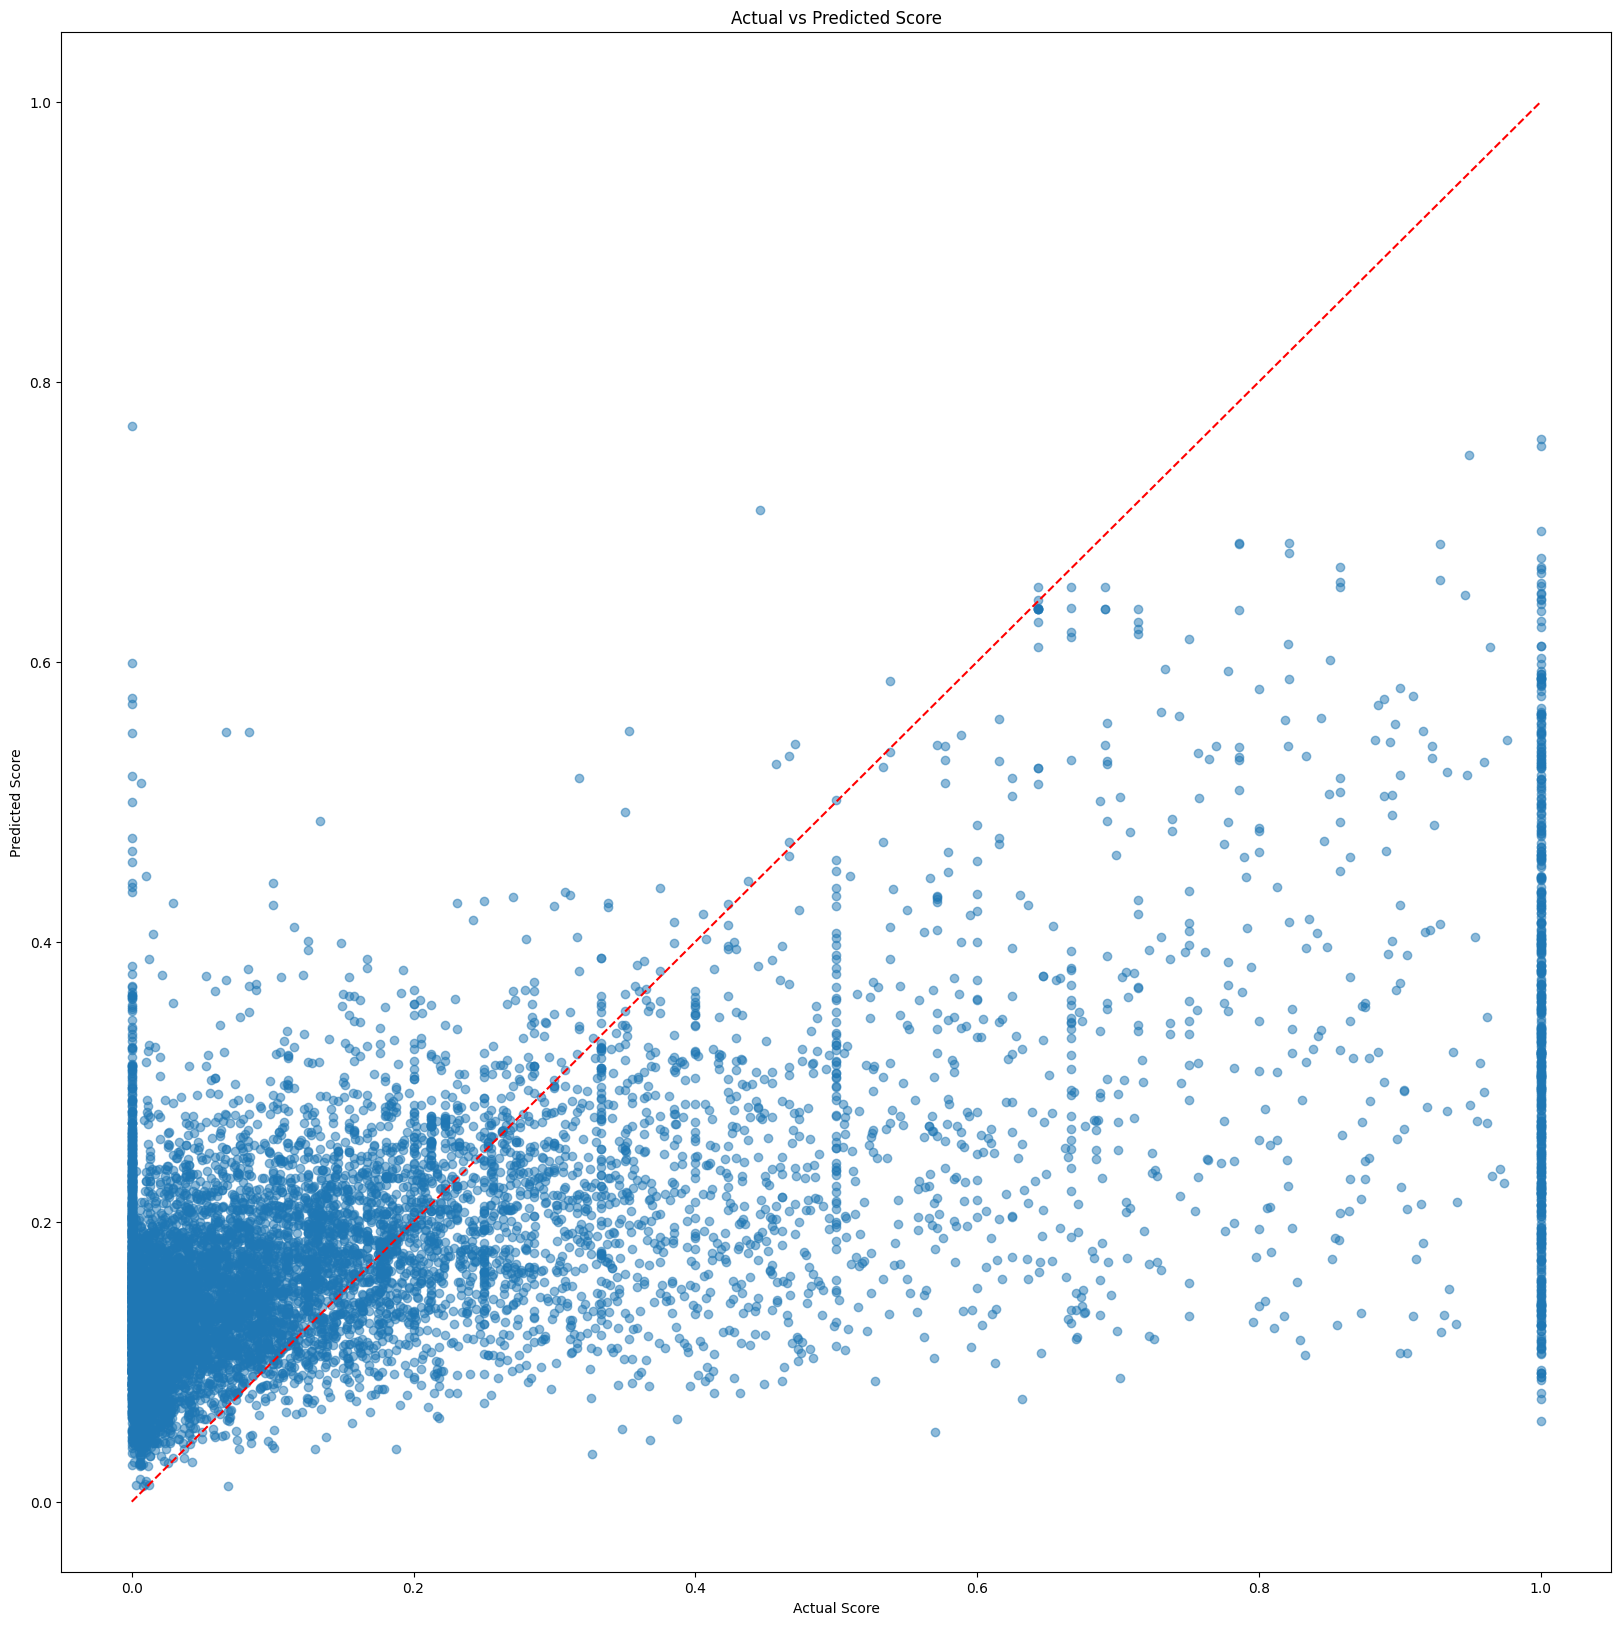

In [115]:
# kicsit nagy de legalább minden látszik
plt.figure(figsize=(20, 20))
plt.scatter(df['score'], df['lin_reg_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Actual vs Predicted Score')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()

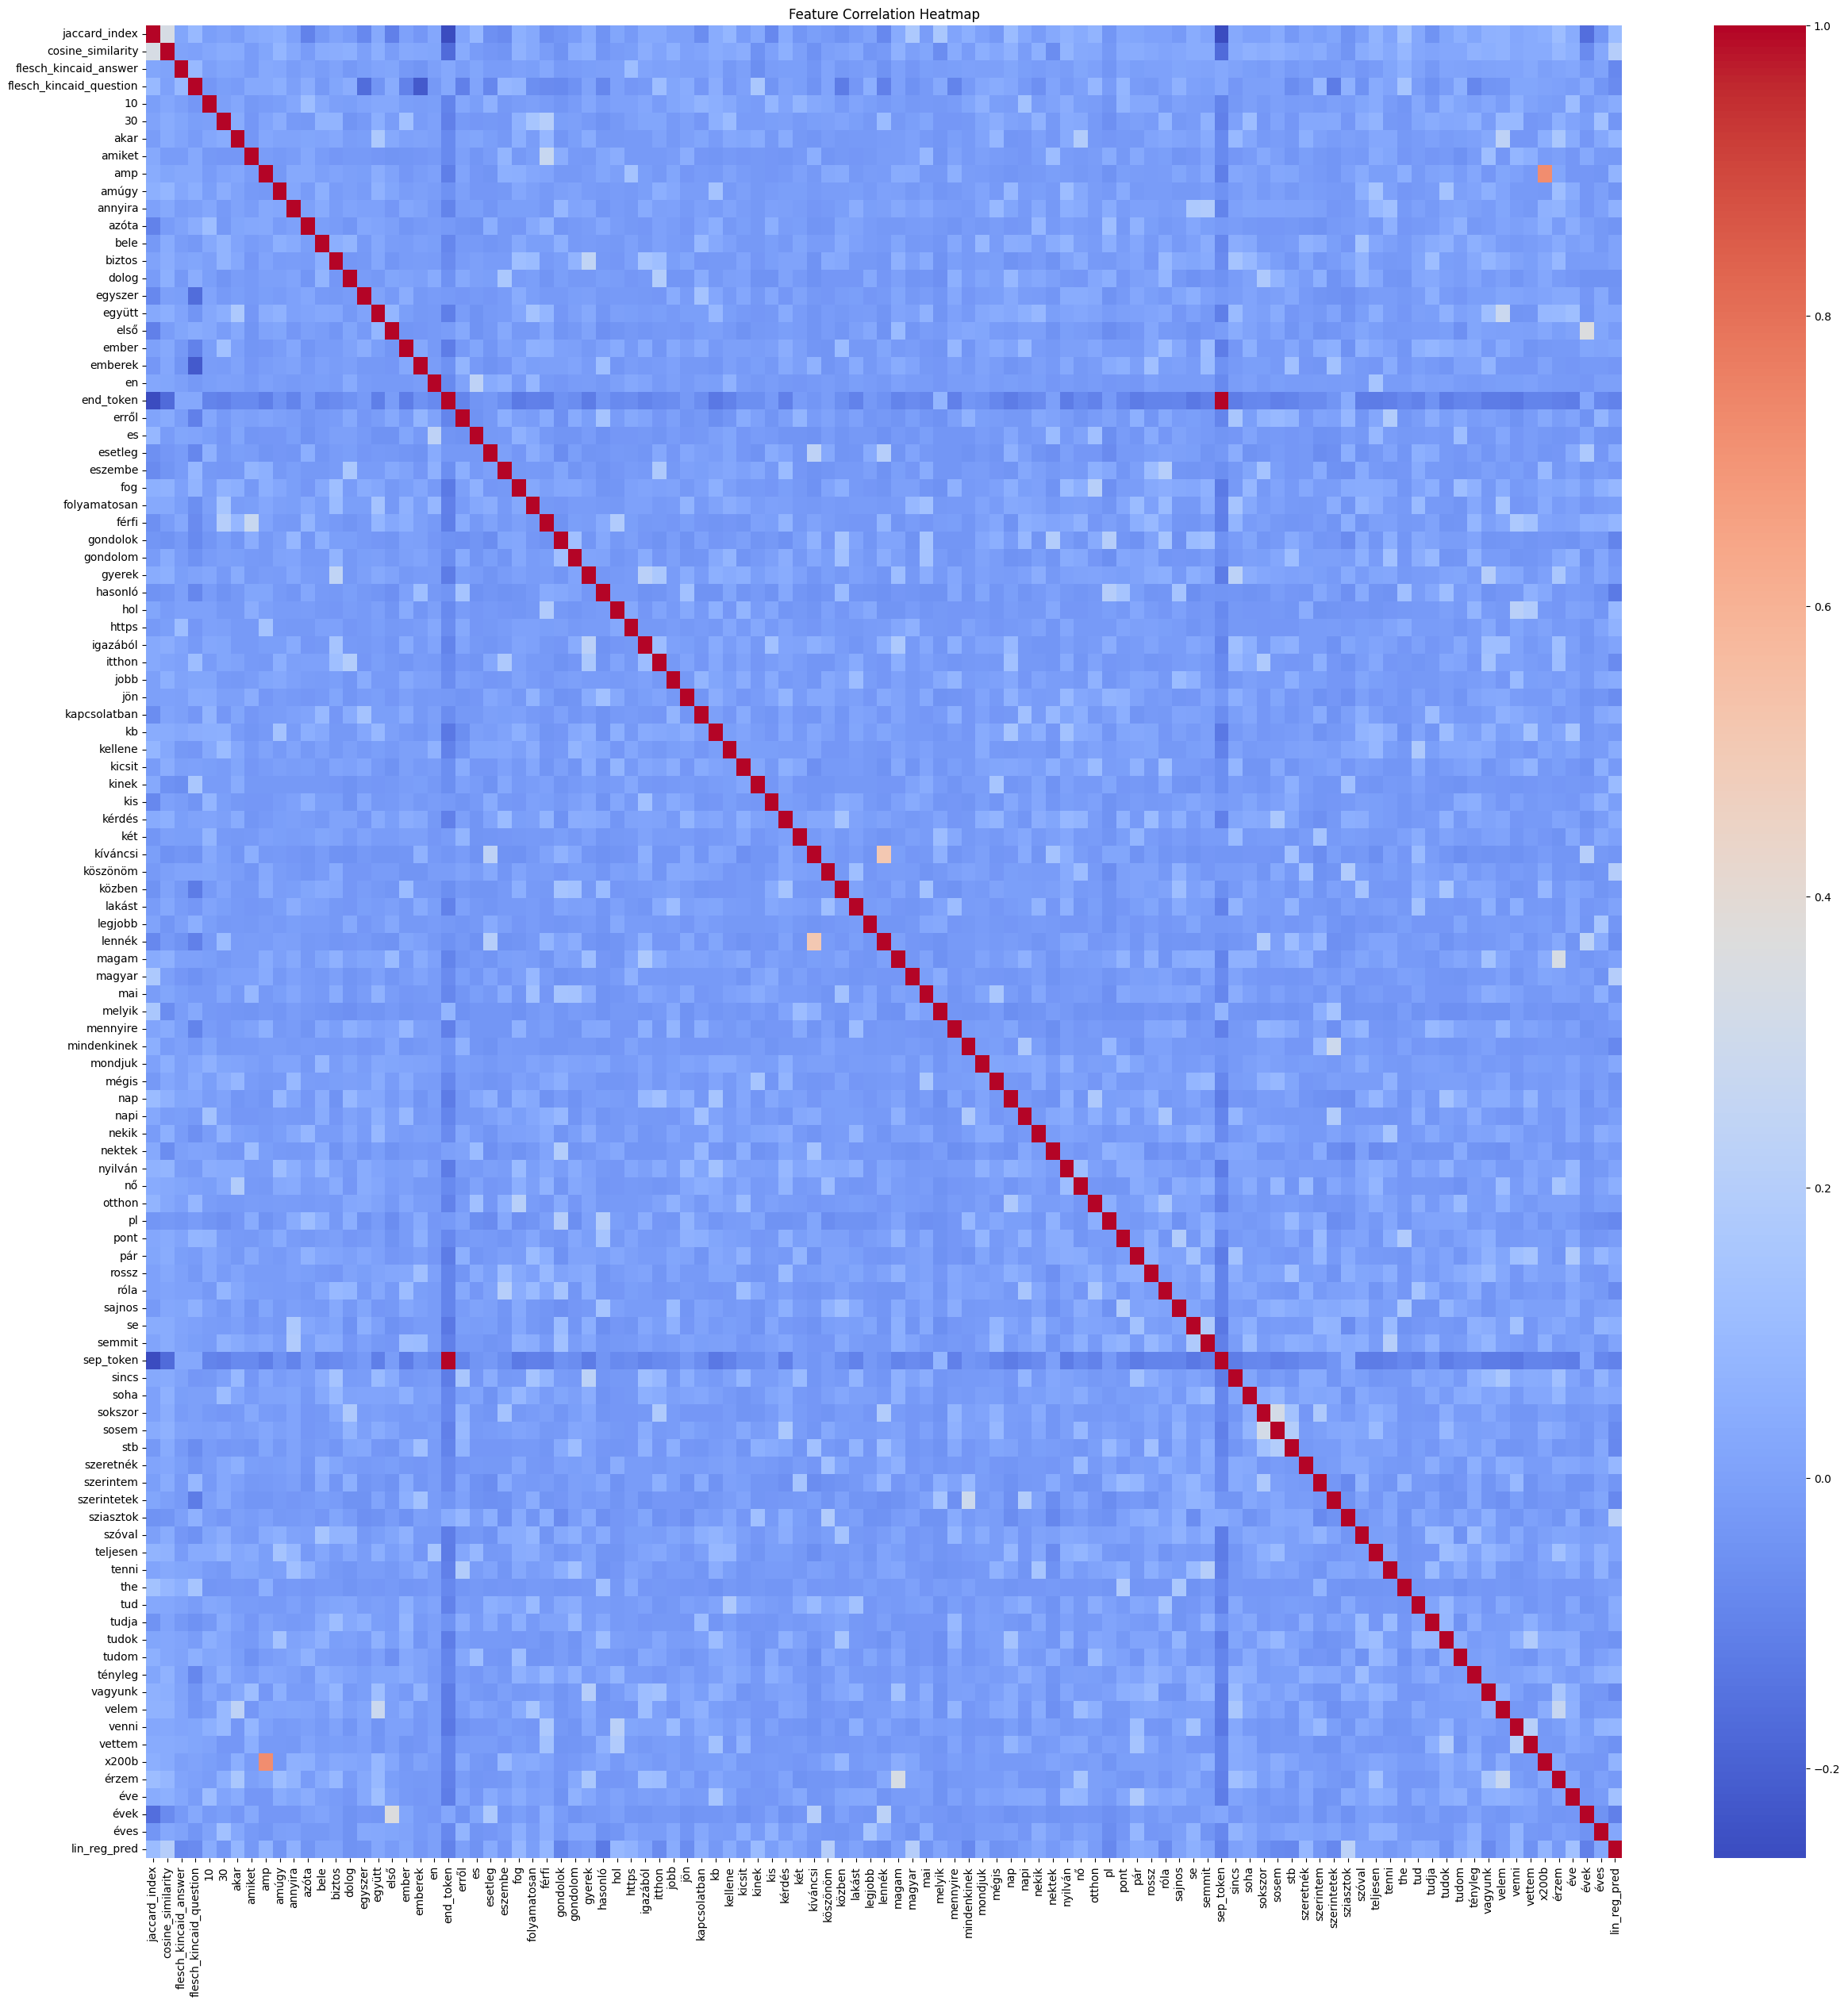

In [103]:
import seaborn as sns

# Korrelációs mátrix
corr_matrix = X.corr()

# Heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()

In [118]:
from scipy.stats import zscore

# generated code
z_scores = np.abs(zscore(df.select_dtypes(include=np.number)))
outliers = (z_scores > 3).any(axis=1)

df[outliers]

,question,answer,tokenized_question,tokenized_answer,score,common_words,jaccard_index,cosine_similarity,flesch_kincaid_answer,flesch_kincaid_question,lin_reg_pred
0,mi történik a bölcsiben a nem alvó gyerekkel? ...,általában a legkisebb egyéni igény/probléma es...,"[történik, bölcsiben, alvó, gyerekkel, kisfiam...","[legkisebb, egyéni, igény/probléma, esetén, ké...",1.000000,"[haza, történik, gyerekkel, sír, többi]",0.048544,0.040978,61.992981,61.421943,0.272144
26,ez oké kéne legyen 2024ben? a helyzet a követk...,"minimál órabér 1534 forint/óra, a te fizetésed...","[oké, kéne, 2024ben, helyzet, következő, havi,...","[minimál, órabér, 1534, forint/óra, fizetésed,...",1.000000,[se],0.020408,0.125081,80.097647,57.795998,0.260251
39,mit lehet tudni pierre woodmanről és a woodman...,"az hozta meg a nézettséget, hogy elment a néze...","[tudni, pierre, woodmanről, woodman, castingró...","[hozta, nézettséget, elment, nézettségi, kör, ...",1.000000,"[valamit, erőszak, tudni, pierre, woodman, fér...",0.073171,0.059813,62.455000,46.131382,0.430125
52,magyar cigaretták minősége? csak én érzékelem ...,mar rakot szerezni se olyan mint regen smh,"[magyar, cigaretták, minősége, érzékelem, amió...","[mar, rakot, szerezni, se, regen, smh]",1.000000,"[magyar, minősége, dobozos, cigik, cigit, cigi...",0.083333,0.009515,71.815000,43.413418,0.320367
67,visszafele beszélni tud valaki? sziasztok! tud...,"én örülök, ha előrefele megy...","[visszafele, beszélni, tud, sziasztok, tud, es...","[örülök, előrefele, megy]",1.000000,"[visszafele, beszélni, tud, kimondani]",0.114286,0.008829,90.958571,54.854135,0.303041
...,...,...,...,...,...,...,...,...,...,...,...
10437,szerintetek melyik munkák vannak túl/alul fize...,"túl: magyar focisták. egészen elképesztő, hogy...","[szerintetek, melyik, munkák, túl/alul, fizetv...","[magyar, focisták, egészen, elképesztő, nb1ben...",1.000000,[],0.000000,0.152999,95.688182,63.234643,0.459890
10439,szerintetek melyik munkák vannak túl/alul fize...,"bírósági fogalmazók, bírósági titkárok, ügyész...","[szerintetek, melyik, munkák, túl/alul, fizetv...","[bírósági, fogalmazók, bírósági, titkárok, ügy...",0.346154,"[bírósági, fogalmazók, fizetve]",0.150000,0.327156,-24.408235,63.234643,0.226172
10443,csak nekem iszonyatosan kínos a magyar nyelvű ...,mert az angol nem az anyanyelved igy meg ha er...,"[iszonyatosan, kínos, magyar, nyelvű, erotika,...","[angol, anyanyelved, igy, erted, feszengsz, ra...",1.000000,"[ugyanez, kínos, magyar, nyelvű, magyarul]",0.084746,0.065020,71.781579,44.519293,0.445826
10444,csak nekem iszonyatosan kínos a magyar nyelvű ...,nekem a szekunder szégyenérzet szó is pont ann...,"[iszonyatosan, kínos, magyar, nyelvű, erotika,...","[szekunder, szégyenérzet, szó, pont, annyira, ...",0.900000,"[szekunder, annyira, kínos, angolul, magyar, n...",0.122807,0.276334,37.455385,44.519293,0.581517


In [123]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3],
    'learning_rate': [0.1],
    'n_estimators': [251],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1
)
grid_search.fit(X_train,y_train)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 251, 'subsample': 0.8}
Best RMSE: 0.24797429383211073


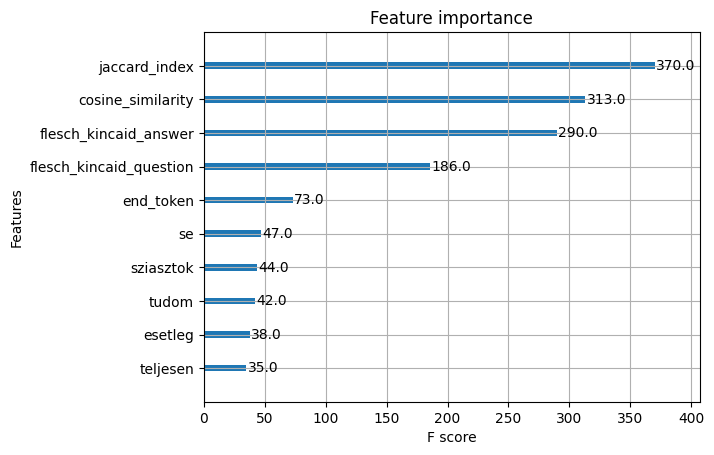

In [88]:
booster = model.get_booster()

importance = booster.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

xgb.plot_importance(booster, importance_type='weight', max_num_features=10)
plt.show()

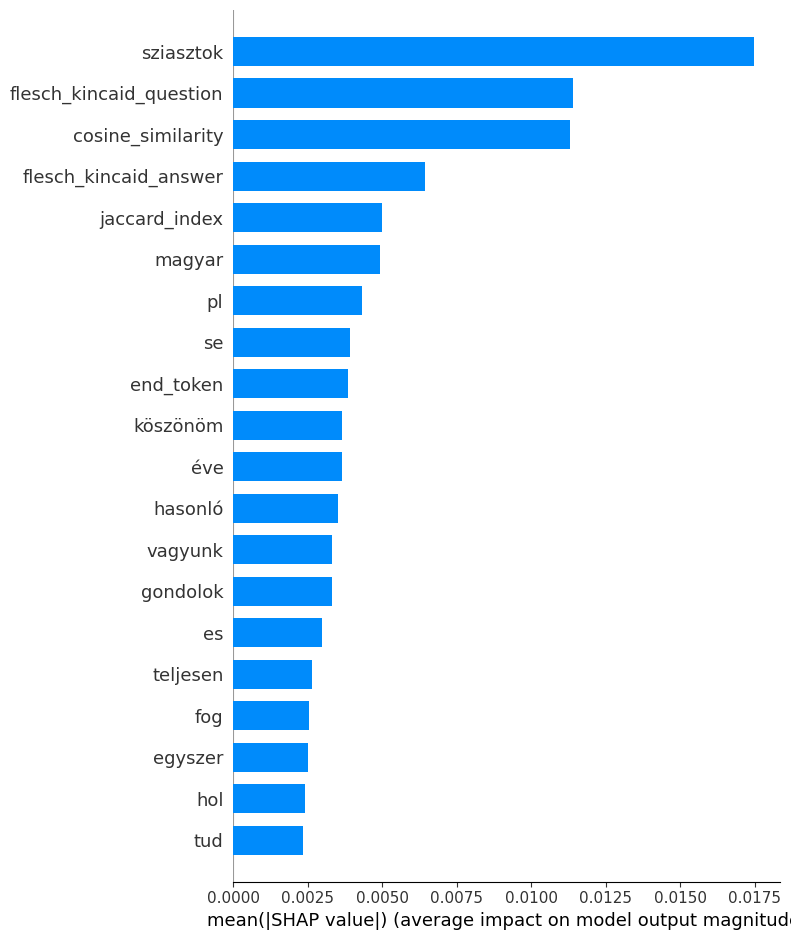

In [89]:
# shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# TODO
# shap.dependence_plot(feature_name, shap_values, X)

In [90]:
# if we let it have some sort of error threshold it works much much better
print('---------------[train]---------------')
train_results = linear_regression_with_threshold(X_train,y_train,model,error_threshold=ERROR_THRESHOLD)
print('---------------[test]----------------')
test_results = linear_regression_with_threshold(X_test,y_test,model,error_threshold=ERROR_THRESHOLD)

---------------[train]---------------


Regressing...: 100%|██████████| 9408/9408 [00:06<00:00, 1436.78it/s]


[ACCURACY] 84.30059523809523%
---------------[test]----------------


Regressing...: 100%|██████████| 1046/1046 [00:00<00:00, 1607.93it/s]


[ACCURACY] 79.92351816443595%


In [ ]:
#szimuláció a reddit-et ismerve
question = 'Milyen színű a piros kisautó?'

questions = []
answers = []
results = []

questions.append('Milyen színű a piros kisautó?')
answers.append('piros.')
answers.append('nagyon piros.')
answers.append('talán piros?')
answers.append('piros kisautó piros kisautó piros kisautó')
answers.append('Lehet csak megérzés, de szerintem piros lehet!')
answers.append('kék.')
answers.append('kék színű')
answers.append('kisautó színű')
answers.append('szofisztikált véleményem szerint, a válasz eme kérdésre az együgyü cinóberpiros és vérvörös közt található épp félúton...')
questions *= len(answers)

#TODO to be able to use it with multiple qa at once
for i in range(len(answers)):
   result = predict_linear(questions[i],answers[i],model)
   results.append(result[0])

df_qas = pd.DataFrame([questions,answers,results],index=['question','answer','score']).T
df_qas

Cleaning some stuff up: 100%|██████████| 1/1 [00:00<00:00, 1599.05it/s]
Getting common words between questions and answers: 100%|██████████| 1/1 [00:00<00:00, 2344.50it/s]
Calculating cosine similarity for each question - answer pair: 100%|██████████| 1/1 [00:00<00:00, 588.34it/s]
Calculating Flesch-Kincaid score for each question and answer: 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]
Preparing questions and answers for vectorization: 100%|██████████| 1/1 [00:00<00:00, 1916.96it/s]
Cleaning some stuff up: 100%|██████████| 1/1 [00:00<00:00, 1008.49it/s]
Getting common words between questions and answers: 100%|██████████| 1/1 [00:00<00:00, 2678.36it/s]
Calculating cosine similarity for each question - answer pair: 100%|██████████| 1/1 [00:00<00:00, 476.79it/s]
Calculating Flesch-Kincaid score for each question and answer: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]
Preparing questions and answers for vectorization: 100%|██████████| 1/1 [00:00<00:00, 2228.64it/s]
Cleaning some stuff 

,question,answer,score
0,Milyen színű a piros kisautó?,piros.,0.198954
1,Milyen színű a piros kisautó?,nagyon piros.,0.202522
2,Milyen színű a piros kisautó?,talán piros?,0.202522
3,Milyen színű a piros kisautó?,piros kisautó piros kisautó piros kisautó,0.237133
4,Milyen színű a piros kisautó?,"Lehet csak megérzés, de szerintem piros lehet!",0.201775
5,Milyen színű a piros kisautó?,kék.,0.169963
6,Milyen színű a piros kisautó?,kék színű,0.215611
7,Milyen színű a piros kisautó?,kisautó színű,0.237133
8,Milyen színű a piros kisautó?,"szofisztikált véleményem szerint, a válasz eme...",0.182111


In [ ]:
runs = pd.DataFrame(np.array(rows),columns=['test_size','n_estimators','learning_rate','max_depth','rmse'])
runs.sort_values(by=['rmse'])
runs.to_csv('linear_regression_runs.csv')
runs

,test_size,n_estimators,learning_rate,max_depth,rmse
0,0.1,251.0,0.1,4.0,0.237237
1,0.1,1000.0,0.1,10.0,0.261517
2,0.1,1000.0,0.1,10.0,0.261517
3,0.1,1000.0,0.1,10.0,0.261517
4,0.1,251.0,0.1,4.0,0.237237


In [ ]:
# for testing
prev_runs=pd.read_csv('https://github.com/yarathealmighty/dumps/blob/main/runs/linear_regression_runs.csv?raw=True')

In [ ]:
sorted_influences = utils.calculate_parameter_influence(prev_runs)
print(sorted_influences)

test_size        0.705013
learning_rate    0.624488
Unnamed: 0       0.533896
max_depth        0.377664
n_estimators     0.058507
Name: rmse, dtype: float64


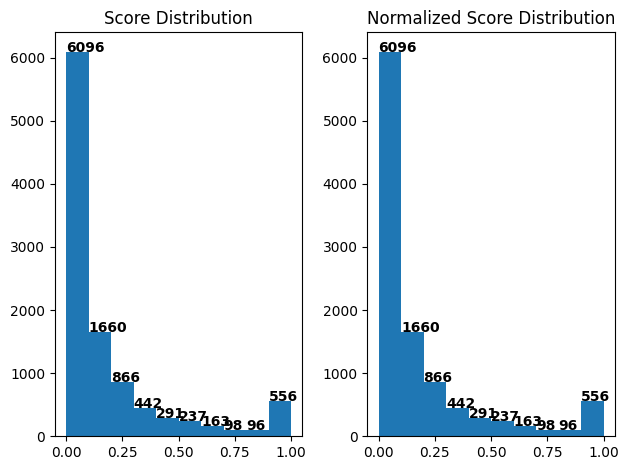

In [ ]:
# plot scores
Sfig, axs = plt.subplots(1, 2, tight_layout=True)

axs[0].set_title("Score Distribution")
axs[1].set_title("Normalized Score Distribution")

score_distribution = axs[0].hist(df['score'], bins=10)
normalized_score_distribution = axs[1].hist(normalized['score'], bins=10)

for distributions, ax in zip([score_distribution, normalized_score_distribution], axs):
    for j in range(10):
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")

plt.show()

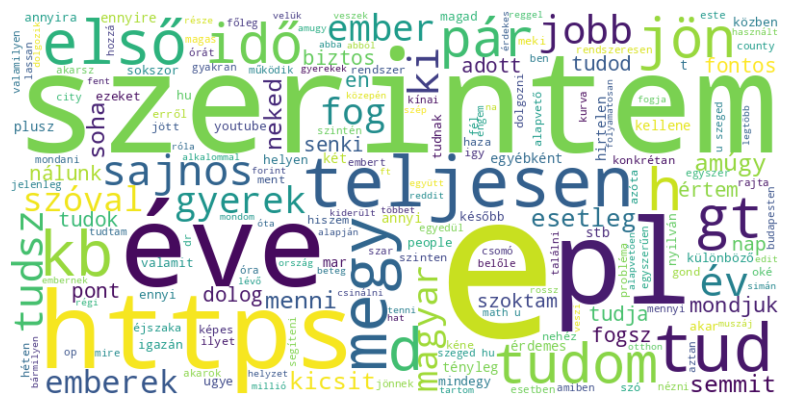

In [ ]:
# best answers wordcloud
idx = df.groupby('question')['score'].idxmax()
highest_scores_df = df5.loc[idx]

combined_answers = ' '.join(highest_scores_df['answer'].tolist())

doc = nlp_hu(combined_answers)
filtered_words = [token.text for token in doc if not token.is_stop and not token.is_punct and token.text != 'se' and token.text != 'e']

filtered_text = ' '.join(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

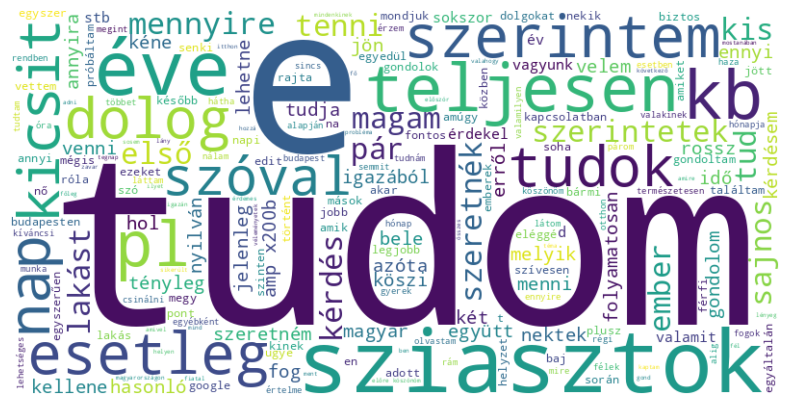

In [ ]:
# questions wordcloud
questions = []
prev = ''
for row in df.iterrows():
  if row[1]['question'] != prev:
    questions.append(row[1]['question'])
    prev = row[1]['question']

text = " ".join(q for q in questions)

doc = nlp_hu(text)
filtered_tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and token.text != 'se' and token.text != 'e']

filtered_text = " ".join(filtered_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from huggingface_hub import HfApi, HfFolder
import pandas as pd

# Your Hugging Face repo
repo_id = "yarathealmighty/hurQA"

# Path to save the dataframe locally before upload
df_path = "big_qas.csv"

# Upload the file to your Hugging Face dataset repo
api = HfApi()
api.upload_file(
    path_or_fileobj=df_path,
    path_in_repo="train.csv",
    repo_id=repo_id,
    repo_type="dataset"  # Specify this is a dataset repo
)

big_qas.csv:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/yarathealmighty/hurQA/commit/eeaf9e25db66076c87ea76d5b2a4714ab02820d4', commit_message='Upload train.csv with huggingface_hub', commit_description='', oid='eeaf9e25db66076c87ea76d5b2a4714ab02820d4', pr_url=None, pr_revision=None, pr_num=None)